In [1]:
import numpy as np
import pandas as pd
import tqdm

In [2]:
data_dir = '/home/vadim/playlist_generation/data/random_data'

### Загружаем mpd_data(Million playlist dataset)

In [3]:
mpd_data = pd.read_csv('{}/transactions.csv'.format(data_dir), index_col=0)
mpd_data.head()

,pid,trackid
2429,822032,2283
2434,822032,2288
2435,822032,907
2440,822032,896
2441,822032,901


### Определяем рейтинг единичкой

In [4]:
mpd_data['rating'] = 1
mpd_data.head()

,pid,trackid,rating
2429,822032,2283,1
2434,822032,2288,1
2435,822032,907,1
2440,822032,896,1
2441,822032,901,1


### Обрежем mpd_data по пользователям для быстроты

In [5]:
data = mpd_data

In [6]:
data.shape

(72955, 3)

In [7]:
from polara.recommender.data import RecommenderData
from polara.recommender.models import SVDModel
from sklearn.model_selection import KFold

In [8]:
def cross_validation_svd(data, n_splits=5, seed=1, test_size=0.05, topk=500, rank=10):
    kf = KFold(n_splits=n_splits, random_state=seed)
    i = 1
    scores = {'precision': [], 'recall': [], 'miss_rate': [], 'nDCG': []}
    for users_ids, unseen_users_ids in kf.split(data['pid'].drop_duplicates()):
        print('=========================Fold {}============================='.format(i))
        i += 1
        users = data['pid'].drop_duplicates().values[users_ids]
        unseen_users = data['pid'].drop_duplicates().values[unseen_users_ids]
        train = data.query('pid in @users')
        test = data.query('pid in @unseen_users')
        test_sampled = test.sample(frac=1-test_size, random_state=seed).sort_values('pid')
        test_holdout = test[~test.index.isin(test_sampled.index)]
        
        data_model = RecommenderData(train,'pid', 'trackid', 'rating', seed=seed)
        data_model.prepare_training_only()
        svd = SVDModel(data_model)
        svd.rank = rank
        svd.build()
        
        data_model.set_test_data(testset=test_sampled, holdout=test_holdout, warm_start=True)
        svd.switch_positive = 1
        svd.topk = topk
        hits = svd.evaluate()
        relevance = svd.evaluate('relevance')
        ranking = svd.evaluate('ranking')
        
        print(hits)
        
        scores['precision'].append(relevance.precision)
        scores['recall'].append(relevance.recall)
        scores['miss_rate'].append(relevance.miss_rate)
        scores['nDCG'].append(ranking.nDCG)
        
    result = pd.DataFrame(scores)
    return result

In [9]:
topks = [500]
ranks = [3,4,5,10, 25, 50, 100, 200]
recall = []
nDCG = []
precision = []
miss_rate = []
for rank in tqdm.tqdm(ranks):
    print('             ===========rank={}============='.format(rank))
    print(data.shape)
    result = cross_validation_svd(data, topk=10, test_size=0.1, rank=rank)
    recall.append(result.recall.mean())
    nDCG.append(result.nDCG.mean())
    precision.append(result.precision.mean())
    miss_rate.append(result.miss_rate.mean())

  0%|          | 0/8 [00:00<?, ?it/s]

             ===========rank=3=============
(72955, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.11694298299971706s
302 unique trackid's within 324 testset interactions were filtered. Reason: not in the training data.
43 unique trackid's within 43 holdout interactions were filtered. Reason: not in the training data.
164 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=104, false_positive=0, true_negative=0, false_negative=1308)
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.03486535999991247s
254 unique trackid's within 272 testset interactions were filtered. Reason: not in the training data.
24 unique trackid's within 24 holdout interactions were filtered. Reason: not in the training data.
154 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=97, false_positive=0, true_neg

 12%|█▎        | 1/8 [00:01<00:11,  1.60s/it]

Hits(true_positive=85, false_positive=0, true_negative=0, false_negative=1362)
             ===========rank=4=============
(72955, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.03638350800019907s
302 unique trackid's within 324 testset interactions were filtered. Reason: not in the training data.
43 unique trackid's within 43 holdout interactions were filtered. Reason: not in the training data.
164 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=128, false_positive=0, true_negative=0, false_negative=1284)
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.02315348100000847s
254 unique trackid's within 272 testset interactions were filtered. Reason: not in the training data.
24 unique trackid's within 24 holdout interactions were filtered. Reason: not in the training data.
154 pid's were filtered out from testset. Reaso

 25%|██▌       | 2/8 [00:03<00:09,  1.57s/it]

Hits(true_positive=115, false_positive=0, true_negative=0, false_negative=1332)
             ===========rank=5=============
(72955, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.029936303999875236s
302 unique trackid's within 324 testset interactions were filtered. Reason: not in the training data.
43 unique trackid's within 43 holdout interactions were filtered. Reason: not in the training data.
164 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=146, false_positive=0, true_negative=0, false_negative=1266)
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.05116222900005596s
254 unique trackid's within 272 testset interactions were filtered. Reason: not in the training data.
24 unique trackid's within 24 holdout interactions were filtered. Reason: not in the training data.
154 pid's were filtered out from testset. Rea

 38%|███▊      | 3/8 [00:05<00:08,  1.67s/it]

Hits(true_positive=127, false_positive=0, true_negative=0, false_negative=1320)
             ===========rank=10=============
(72955, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.034052863999932015s
302 unique trackid's within 324 testset interactions were filtered. Reason: not in the training data.
43 unique trackid's within 43 holdout interactions were filtered. Reason: not in the training data.
164 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=212, false_positive=0, true_negative=0, false_negative=1200)
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.03575138299993341s
254 unique trackid's within 272 testset interactions were filtered. Reason: not in the training data.
24 unique trackid's within 24 holdout interactions were filtered. Reason: not in the training data.
154 pid's were filtered out from testset. Re

 50%|█████     | 4/8 [00:06<00:06,  1.63s/it]

             ===========rank=25=============
(72955, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.12216063400001076s
302 unique trackid's within 324 testset interactions were filtered. Reason: not in the training data.
43 unique trackid's within 43 holdout interactions were filtered. Reason: not in the training data.
164 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=303, false_positive=0, true_negative=0, false_negative=1109)
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.12755034300016632s
254 unique trackid's within 272 testset interactions were filtered. Reason: not in the training data.
24 unique trackid's within 24 holdout interactions were filtered. Reason: not in the training data.
154 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=290, false_positive=0, true_n

 62%|██████▎   | 5/8 [00:08<00:04,  1.64s/it]

Hits(true_positive=273, false_positive=0, true_negative=0, false_negative=1174)
             ===========rank=50=============
(72955, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.3841771769998559s
302 unique trackid's within 324 testset interactions were filtered. Reason: not in the training data.
43 unique trackid's within 43 holdout interactions were filtered. Reason: not in the training data.
164 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=342, false_positive=0, true_negative=0, false_negative=1070)
=========================Fold 2=============================
Preparing data...
Done.
PureSVD training time: 0.3264883439996993s
254 unique trackid's within 272 testset interactions were filtered. Reason: not in the training data.
24 unique trackid's within 24 holdout interactions were filtered. Reason: not in the training data.
154 pid's were filtered out from testset. Reaso

 75%|███████▌  | 6/8 [00:11<00:03,  1.87s/it]

PureSVD training time: 0.2426439119999486s
290 unique trackid's within 326 testset interactions were filtered. Reason: not in the training data.
28 unique trackid's within 28 holdout interactions were filtered. Reason: not in the training data.
157 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=310, false_positive=0, true_negative=0, false_negative=1137)
             ===========rank=100=============
(72955, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 0.7429618119999759s
302 unique trackid's within 324 testset interactions were filtered. Reason: not in the training data.
43 unique trackid's within 43 holdout interactions were filtered. Reason: not in the training data.
164 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=322, false_positive=0, true_negative=0, false_negative=1090)
=========================Fold 2=======================

 88%|████████▊ | 7/8 [00:17<00:02,  2.46s/it]

PureSVD training time: 1.0386829120002403s
290 unique trackid's within 326 testset interactions were filtered. Reason: not in the training data.
28 unique trackid's within 28 holdout interactions were filtered. Reason: not in the training data.
157 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=320, false_positive=0, true_negative=0, false_negative=1127)
             ===========rank=200=============
(72955, 3)
=========================Fold 1=============================
Preparing data...
Done.
PureSVD training time: 4.412477634999959s
302 unique trackid's within 324 testset interactions were filtered. Reason: not in the training data.
43 unique trackid's within 43 holdout interactions were filtered. Reason: not in the training data.
164 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=340, false_positive=0, true_negative=0, false_negative=1072)
=========================Fold 2========================

100%|██████████| 8/8 [00:37<00:00,  4.65s/it]

PureSVD training time: 3.236294139000165s
290 unique trackid's within 326 testset interactions were filtered. Reason: not in the training data.
28 unique trackid's within 28 holdout interactions were filtered. Reason: not in the training data.
157 pid's were filtered out from testset. Reason: inconsistent with holdout.
Hits(true_positive=317, false_positive=0, true_negative=0, false_negative=1130)


In [12]:
import matplotlib.pyplot as plt

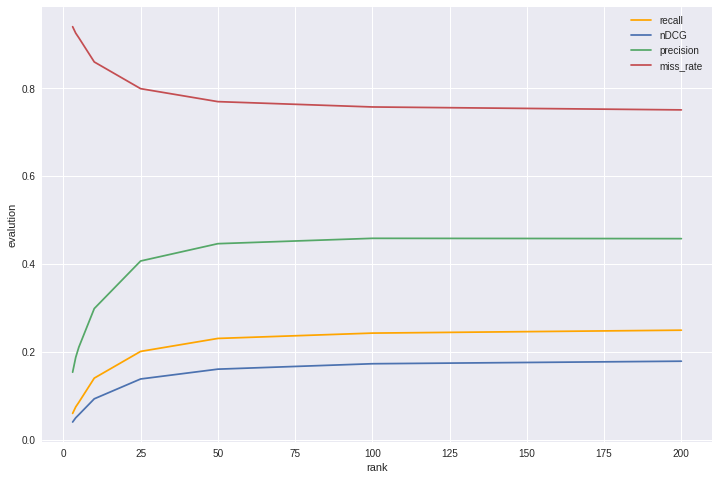

In [13]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot(ranks, recall, 'orange', label='recall')
plt.plot(ranks, nDCG,label='nDCG')
plt.plot(ranks, precision, label='precision')
plt.plot(ranks, miss_rate, label='miss_rate')
plt.ylabel('evalution')
plt.xlabel('rank')
plt.legend()
plt.show()